<a href="https://colab.research.google.com/github/OnePassio/CE888/blob/master/Assignment2/Experiment_4_Build_Prediction_deal_with_Covariance_(Importance_weight_using_Density_Ratio_Estimation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Target of this experiment**
- This experiment target: Detect Covariant shift features by calculate importance weight using Density Ratio Estimation, and then building a classifier model with these weights parameters
- The result will be upload to Kaggle to check score.
- Result:
   + 4-Kfold stratified cross-validation: **0.61965 +/- 0.00119**
   + **Kaggle score**: **0.60330**

## **Load Library**

In [0]:
# Initial Library
# data analysis
import pandas as pd
import numpy as np
import random as rand

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warning message
import warnings
warnings.filterwarnings('ignore')

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **1.Load Data from Kaggle**
Source Data: https://www.kaggle.com/c/microsoft-malware-prediction/

!kaggle competitions download -c microsoft-malware-prediction

In [0]:
# load data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "thomastran89" # username from the json file
os.environ['KAGGLE_KEY'] = "be79bdf7a2010c5b7a9aeac8ed316490" # key from the json file
!kaggle competitions download -c microsoft-malware-prediction # api copied from kaggle
# Unzip the data
!sample_submission.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip
# Check files after unzip
!ls

 84% 113M/134M [00:01<00:00, 96.8MB/s] 
100% 134M/134M [00:01<00:00, 111MB/s] 
 99% 757M/768M [00:06<00:00, 136MB/s]
100% 768M/768M [00:06<00:00, 121MB/s]
 98% 660M/672M [00:05<00:00, 134MB/s]
100% 672M/672M [00:05<00:00, 137MB/s]
/bin/bash: sample_submission.csv.zip: command not found
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
as2_experiment01.csv  sample_data		 test.csv.zip
fixed_data	      sample_submission.csv.zip  train.csv
fixed_data.zip	      test.csv			 train.csv.zip


In [0]:
# load partial data for test first
sample_size= 2000000 # data too heavy and can not load by Google Colab -> Test on 2M first rows for train data

# Load Train Data
df_train_org = pd.read_csv("train.csv",skiprows=0, nrows=sample_size)

# Load Test Data
df_test_org= pd.read_csv("test.csv") #skiprows=0, nrows=sample_size)


# **2. Preprocessing Data**

## 2.1. Remove some unused features to build model of dataset
remove column field data have a unique ID 

In [0]:
#cache
df_train_id=df_test_org['MachineIdentifier'].copy()
df_test_id=df_test_org['MachineIdentifier'].copy()
# remove id
df_train=df_train_org.drop('MachineIdentifier',axis=1)
df_test=df_test_org.drop('MachineIdentifier',axis=1)

df_train.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2341.0,...,HDD,299451.0,0,4096.0,Desktop,18.9,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2405.0,...,HDD,102385.0,0,4096.0,Notebook,13.9,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4909.0,317701.0,4.0,5.0,1972.0,...,SSD,113907.0,0,4096.0,Desktop,21.5,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,2273.0,...,UNKNOWN,227116.0,0,4096.0,MiniTower,18.5,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,355.0,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,18,37376.0,NaN,277.0,75,windows1

### 2.2. Fill NaN missing value
Replace NaN value by mean value of their columns

In [0]:
## missing values on train.csv
for i in df_train.columns:
    if df_train[i].dtype == 'object':
      df_train[i] = df_train[i].fillna(df_train[i].mode().iloc[0])
    if (df_train[i].dtype == 'int' or df_train[i].dtype == 'float'):
      df_train[i] = df_train[i].fillna(np.mean(df_train[i]))

## missing values on test.csv
for i in df_test.columns:
    if df_test[i].dtype == 'object':
      df_test[i] = df_test[i].fillna(df_test[i].mode().iloc[0])
    if (df_test[i].dtype == 'int' or df_test[i].dtype == 'float'):
      df_test[i] = df_test[i].fillna(np.mean(df_test[i]))
      
df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,on,0.003175,108.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,SSD,123179.0,0,8192.0,Notebook,15.5,1920.0,1080.0,Mobile,lion,8.0,10.0.15063.1387,amd64,rs2_release,15063,1387,Core,CORE,Reset,37.0,158,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,0.000011,0.0,Retail,0.000281,807.0,8554.0,1,4.290840e-07,0.0,0,0,0.0,0.0,7.0
1,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,68,71395.0,24.952712,276.0,74,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,1.0,0,on,0.003175,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,HDD,1882352.0,0,8192.0,Notebook,15.5,1366.0,768.0,Mobile,lion,0.0,10.0.16299.611,amd64,rs3_release_svc_escrow,16299,611,Core,CORE,UUPUpgrade,7.0,30,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,Retail,0.000011,0.0,Retail,0.000281,554.0,33105.0,1,4.290840e-07,0.0,0,0,0.0,1.0,12.0
2,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,0,7.0,0,1604.120797,49480.0,2.0,1.0,1,201,66202.0,24.952712,267.0,251,windows10,x64,10.0.0.0,14393,768,rs1,14393.2189.amd64fre.rs1_release.180329-1711,Home,1.0,0,on,0.003175,98.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,SSD,28678.0,0,4096.0,Notebook,13.9,1280.0,720.0,Mobile,lion,0.0,10.0.14393.2189,amd64,rs1_release,14393,2189,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,35.0,148,UNKNOWN,0,IS_GENUINE,OEM:DM,0.000011,0.0,Retail,0.000281,556.0,63396.0,1,4.290840e-07,0.0,0,0,0.0,1.0,11.0
3,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,0,7.0,0,1604.120797,42160.0,2.0,1.0,1,29,120917.0,24.952712,35.0,171,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,on,0.003175,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,HDD,439345.0,0,4096.0,Notebook,14.0,1366.0,768.0,Mobile,li-i,0.0,10.0.16299.371,amd64,rs3_release,16299,371,CoreSingleLanguage,CORE_SINGLEL

## 2.3. label encoding

In [0]:
# encoder, alternative is convert to dummies
number = LabelEncoder()
for i in df_train.columns:
    if (df_train[i].dtype == 'object'):
      df_train[i] = number.fit_transform(df_train[i].astype('str'))
      df_train[i] = df_train[i].astype('object')

for i in df_test.columns:
    if (df_test[i].dtype == 'object'):
      df_test[i] = number.fit_transform(df_test[i].astype('str'))
      df_test[i] = df_test[i].astype('object')

df_test.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,...,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,4,68,70,9261,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,43,58552.0,18.000000,53.0,42,0,1,0,15063,768,2,259,4,1.0,0,1,0.003175,108.0,13,1.0,1.0,8,1,2689.0,30661.0,4.0,5.0,3063.0,...,488386.0,1,123179.0,0,8192.0,33,15.5,1920.0,1080.0,3,42,8.0,255,0,3,15063,1387,4,2,5,37.0,158,0,0,1,0,0.000011,0.0,7,0.000281,807.0,8554.0,1,4.290840e-07,0.0,0,0,0.0,0.0,7.0
1,4,67,64,9005,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,68,71395.0,24.952712,276.0,74,0,1,0,16299,768,3,270,4,1.0,0,1,0.003175,117.0,13,1.0,1.0,8,1,2206.0,242491.0,4.0,5.0,3410.0,...,1907729.0,0,1882352.0,0,8192.0,33,15.5,1366.0,768.0,3,42,0.0,323,0,6,16299,611,4,2,6,7.0,30,0,0,1,2,0.000011,0.0,7,0.000281,554.0,33105.0,1,4.290840e-07,0.0,0,0,0.0,1.0,12.0
2,4,65,64,8501,0,7.0,0,1604.120797,49480.0,2.0,1.0,1,201,66202.0,24.952712,267.0,251,0,1,0,14393,768,1,201,4,1.0,0,1,0.003175,98.0,13,1.0,1.0,8,1,585.0,189533.0,2.0,5.0,2097.0,...,29820.0,1,28678.0,0,4096.0,33,13.9,1280.0,720.0,3,42,0.0,174,0,0,14393,2189,7,5,3,35.0,148,5,0,1,0,0.000011,0.0,7,0.000281,556.0,63396.0,1,4.290840e-07,0.0,0,0,0.0,1.0,11.0
3,4,68,70,9301,0,7.0,0,1604.120797,42160.0,2.0,1.0,1,29,120917.0,24.952712,35.0,171,0,1,0,16299,768,3,266,4,1.0,0,1,0.003175,117.0,13,1.0,1.0,8,1,2668.0,171228.0,2.0,5.0,1985.0,...,476940.0,0,439345.0,0,4096.0,33,14.0,1366.0,768.0,3,37,0.0,312,0,5,16299,371,7,5,8,26.0,119,3,0,1,0,0.000011,0.0,7,0.000000,628.0,26320.0,1,0.000000e+00,0.0,0,0,0.0,0.0,10.0
4,4,67,64,8989,0,7.0,0,1604.120797,53447.0,1.0,1.0,1,171,124736.0,18.000000,211.0,182,0,1,0,16299,768,3,266,4,1.0,0,1,0.003175,117.0,13,1.0,1.0,8,1,585.0,189538.0,4.0,5.0,3394.0,...,476940.0,0,461506.0,1,2048.0,33,15.5,1366.0,768.0,3,42,0.0,312,0,5,16299,371,7,5,7,29.0,125,5,0,1,2,0.000011,0.0,7,0.000281,556.0,63269.0,1,4.290840e-07,0.0,0,0,0.0,1.0,3.0


#**3. Detect Covariate Shift:  Calculate Importance weight using Density Ratio Estimation**

 ### *Indicator for source of origin*

In [0]:
df_train['origin'] = 0
df_test['origin'] = 1

###*Combining train and test*

In [0]:
training = df_train.drop('HasDetections',axis=1) # droping target variable
## taking sample from training and test data
training = training.sample(1000000, random_state=12)
testing = df_test.sample(1000000, random_state=11)
## combining random samples
combi_data = training.append(testing)
y = combi_data['origin'].values #labels
x = combi_data.drop('origin', axis=1).values #covariates or our independent variables
tst, trn = testing.values, training.values

### *Building and testing a classifier*

In [0]:
## modelling
m = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape) #creating an empty prediction array

Using stratified 4 fold to ensure that percentage for each class is preserved and we cover the whole data once

In [0]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
  X_train, X_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]
  m.fit(X_train, y_train)
  probs = m.predict_proba(X_test)[:, 1] #calculating the probability
  predictions[test_idx] = probs

In [0]:
from sklearn.metrics import roc_auc_score
print('ROC-AUC for train and test distributions:', roc_auc_score(y, predictions))

ROC-AUC for train and test distributions: 0.9999999964220001


AUC value of 0.9999999964220001 implies that there is  evidence of strong covariate shift.

### *Weights can be calculated:*

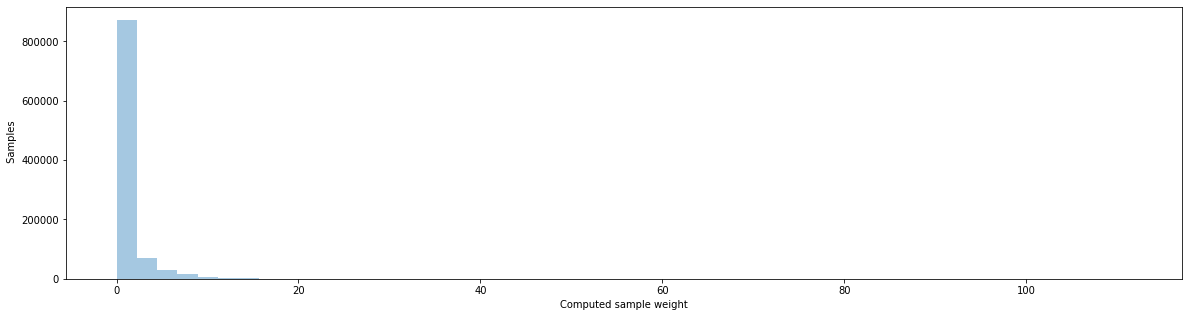

In [0]:
plt.figure(figsize=(20,5))
predictions_train = predictions[len(tst):] #filtering the actual training rows
weights = (1/predictions_train) - 1
weights /= np.mean(weights) # Normalizing the weights
plt.xlabel('Computed sample weight')
plt.ylabel(' Samples')
sns.distplot(weights, kde=False)

In [0]:
weights

array([0.01323518, 0.06147402, 0.03105625, ..., 4.97929507, 0.09532445,
       0.02360247])

# **4. Build classifier prediction**

In [0]:
# get high covariate shift features from 2
drop_list=[]
drop_list.append('origin')# add origin to ignore
remain_features=[]
for x in list(df_test.columns):
  if(x not in drop_list):
    remain_features.append(x)
# show remain features use for build classifier model
remain_features

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'IsBeta',
 'RtpStateBitfield',
 'IsSxsPassiveMode',
 'DefaultBrowsersIdentifier',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'HasTpm',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'AutoSampleOptIn',
 'PuaMode',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'UacLuaenable',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_ProcessorClass',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalR

In [0]:
from sklearn.model_selection import train_test_split

#Get the values and run a classifier 
features= remain_features

# convert to dummies
X=df_train[features]
y=df_train['HasDetections']

# 70% train, 30% test from dataset train.csv
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)


In [0]:
# Build prediction Model with weight
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# main Model
clf = RandomForestClassifier(n_jobs=-1,max_depth=5)#LinearDiscriminantAnalysis()
clf.fit(X_train,y_train, sample_weight=weights)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
# cross validation model
scores = cross_val_score(clf, X_test, y_test, cv=4,scoring=make_scorer(accuracy_score))
#Report the results of 4-Kfold stratified cross-validation
print("ACC: %0.5f +/- %0.5f" % (scores.mean(), scores.std()))

ACC: 0.61965 +/- 0.00119


# **5.Run Predict on test dataset then save to csv and upload result to Kaggle**

In [0]:
# Load Test Data all
#df_test = pd.read_csv("test.csv",skiprows=0)
export_file='as2_experiment06.csv'
features= remain_features
testFeatures=df_test[features].copy()
pred = clf.predict(testFeatures)
columns = ['HasDetections']
sub = pd.DataFrame(data=pred,columns=columns)
sub['MachineIdentifier'] = df_test_id
sub = sub[['MachineIdentifier','HasDetections']]
sub.to_csv(export_file, index=False)

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': export_file})
upload.SetContentFile(export_file)
upload.Upload()